In [412]:
%pip install seaborn

In [413]:
%pip install missingno

In [414]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
import missingno as msno

## 1) EDA (Exploratory Data Analysis)

In [415]:
train = pd.read_csv('titanic/train.csv') #Dados para treino e validação
test = pd.read_csv('titanic/test.csv') #Dados para previsão

In [416]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [417]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

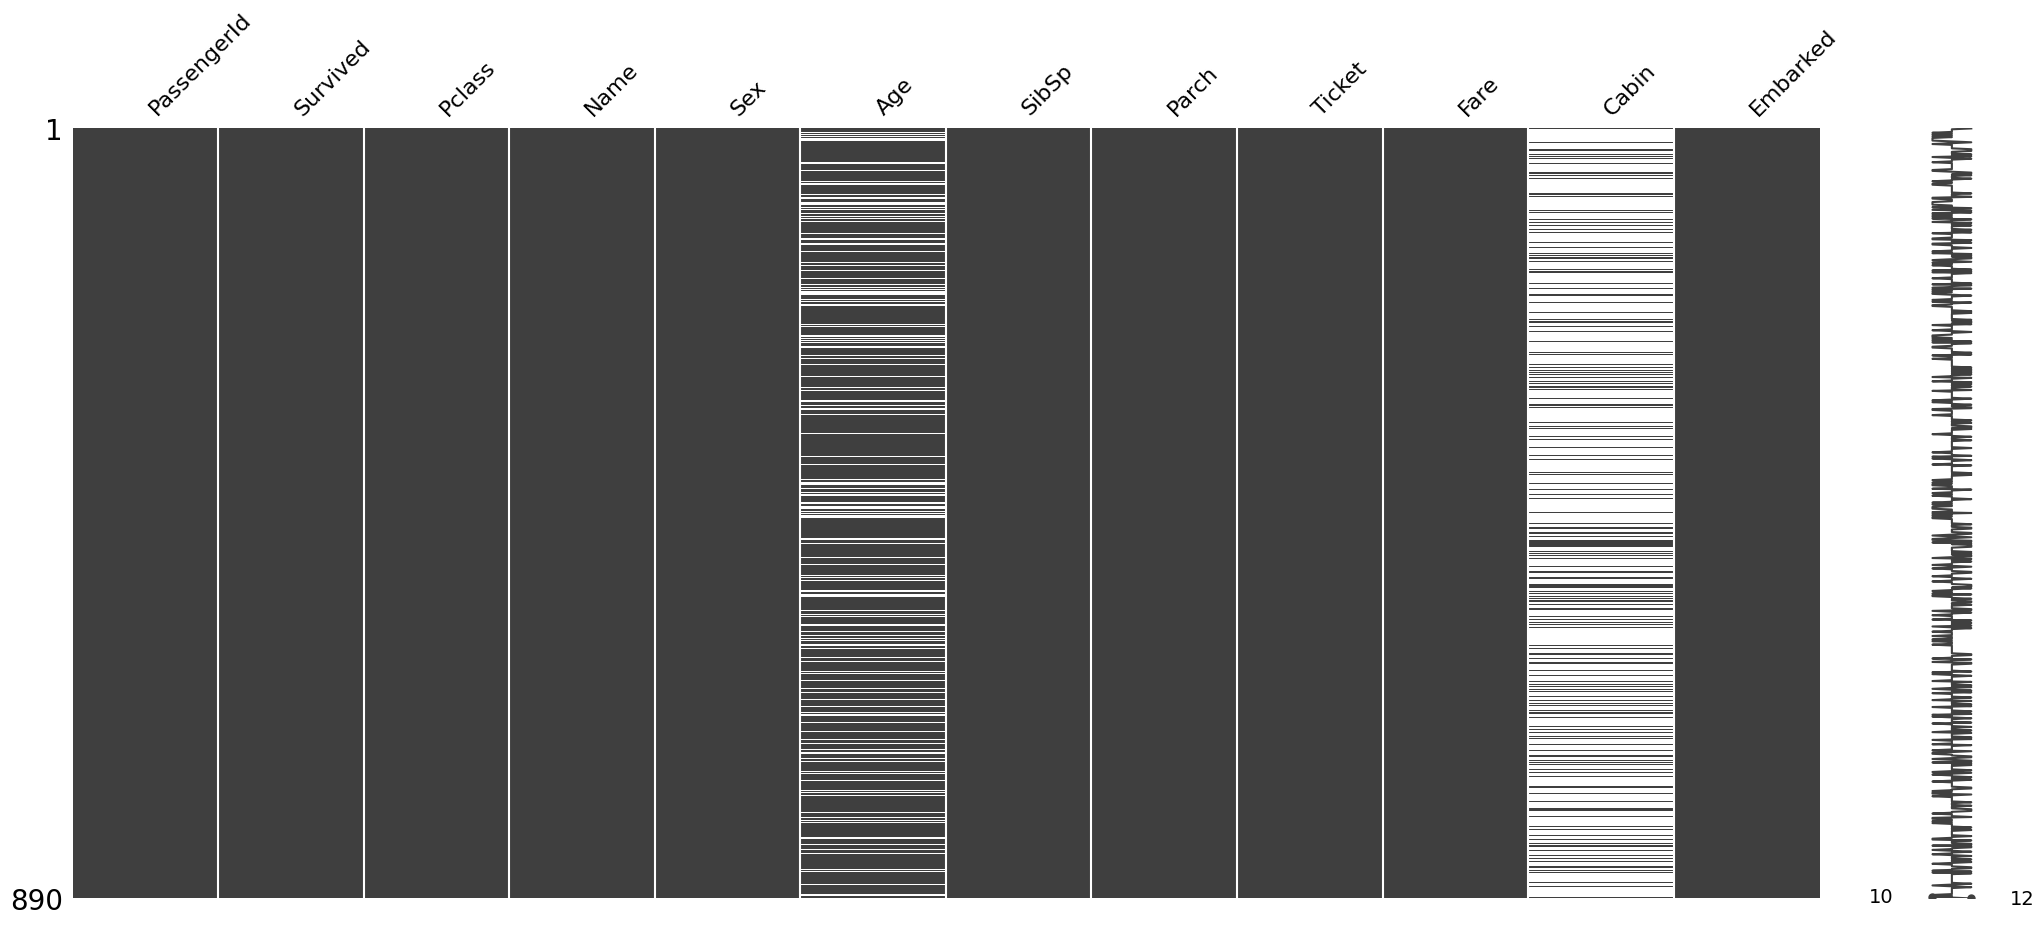

In [418]:
msno.matrix(train.sample(890))  # Matriz de valores ausentes
plt.show()  # Exibir o gráfico

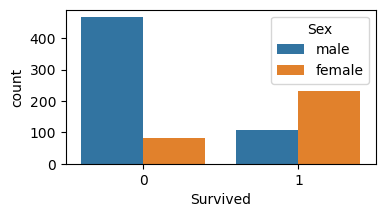

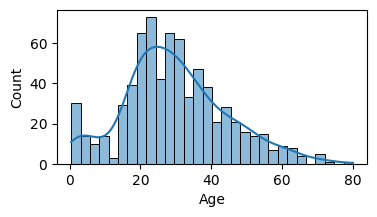

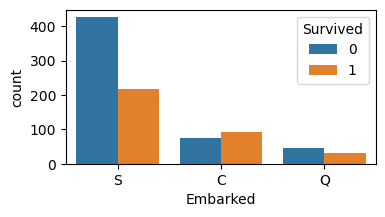

<Figure size 400x200 with 0 Axes>

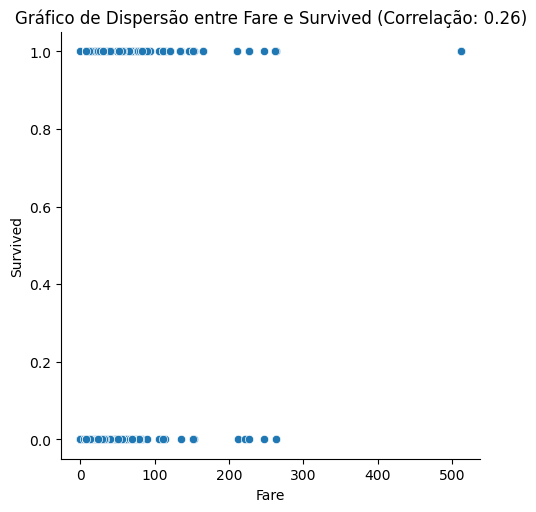

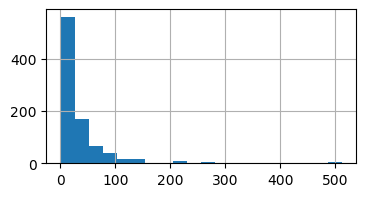

In [419]:
plt.figure(figsize=(4, 2))
sns.countplot(train, x='Survived', hue='Sex')
plt.show()
plt.figure(figsize=(4, 2))
sns.histplot(train["Age"], bins=30, kde=True)  # kde=True adiciona uma curva de densidade
plt.show()

plt.figure(figsize=(4, 2))
sns.countplot(data=train, x="Embarked", hue="Survived")
plt.show()

# Calcular a correlação entre 'Fare' e 'Survived'
correlation = train['Fare'].corr(train['Survived'])
plt.figure(figsize=(4, 2))
sns.relplot(data=train, x="Fare", y="Survived", kind="scatter")
plt.title(f'Gráfico de Dispersão entre Fare e Survived (Correlação: {correlation:.2f})')
plt.show()

plt.figure(figsize=(4, 2))
train["Fare"].hist(bins=20) #posso criar uma variável categórica com "Fare", definindo níveis do custo de passagens para ver se existe alguma correlação com "Survived"
plt.show()

## 2) Processamento (Limpeza e Manipulação)

### Dealing with missing data And Feature Engineering

In [420]:
#getting titles from name / Criando uma feature "Title"
dataset= [train, test] # Cria uma lista de referências aos dataframes train e test 
                       # Isso significa que dataset[0] é uma referência ao dataframe train, e dataset[1] é uma referência ao dataframe test. Ocupa a mesma memória.
for data in dataset:
    data['Title']= data['Name'].str.extract(pat= ' ([A-Za-z]+)\\.') # Data está atuando como uma "variável intermediária" que aponta para o mesmo objeto em memória que train ou test

train['Title'].unique()
#try with just 4 titles

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [421]:
pd.crosstab(train['Sex'], train['Title'])

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [422]:
for data in dataset:
    data["Title"] = data["Title"].replace(['Ms', 'Mlle'], 'Miss')
    data["Title"] = data["Title"].replace(['Mme', 'Countess', 'Lady'], 'Mrs')
    data["Title"] = data["Title"].replace(['Dr', 'Rev', 'Sir', 'Col', 'Major', 'Capt', 'Jonkheer', 'Don'], 'Mr')

pd.crosstab(train["Title"], train["Survived"])
train[['Title', 'Survived']].groupby(['Title'], as_index=True).mean() #Avalia a hipótese de que a variável "Title" impacta em "Survived", 
                                                                      # i.e. existe diferença se a pessoa sobreviveu dependendo do título que ela possui, o qual está associado com a sua idade,
                                                                      # tornando uma feature poderosa para ajudar a preencher os valores faltantes em "Age"

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.161710
Mrs,0.796875


In [423]:
train["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [424]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [425]:
# preenchendo idade pela média do título dos grupos
train["Age"] = train.groupby("Title")["Age"].transform(lambda x : x.fillna(round(np.mean(x), 0)))
test["Age"] = test.groupby("Title")["Age"].transform(lambda x : x.fillna(round(np.mean(x), 0)))

In [426]:
#filling missing values of Embarked and Fare
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode()[0]) #Embarked com a sua 'Moda'
test["Embarked"] = test["Embarked"].fillna(test["Embarked"].mode()[0])

test["Fare"] = test["Fare"].fillna(test["Fare"].mean())

In [427]:
train = train.assign(Relatives=train['SibSp'] + train['Parch'])
test = test.assign(Relatives=test['SibSp'] + test['Parch'])
train.head(10).sort_values("Fare", ascending=False)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Relatives
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs,2
5,6,0,3,"Moran, Mr. James",male,33.0,0,0,330877,8.4583,NaN,Q,Mr,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1


### Análise do Cabin, isoladamente. + Sua correlação com "Fare", para preencher os valores faltantes de "":

In [428]:
#Lidando com "Cabin"
train["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [429]:
#filling missing values of cabin and using them to create new column deck
#train["Cabin"]= train["Cabin"].fillna("C")
train["Deck"]= train["Cabin"].str[:1]

#test["Cabin"]= test["Cabin"].fillna("C")
test["Deck"]= test["Cabin"].str[:1]
print(train["Deck"].unique())
print(train.info())

[nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Title        891 non-null    object 
 13  Relatives    891 non-null    int64  
 14  Deck         204 non-null    object 
dtypes: float64(2), int64(6), object(7)
memory usage: 80.1+ KB
None


<function matplotlib.pyplot.show(close=None, block=None)>

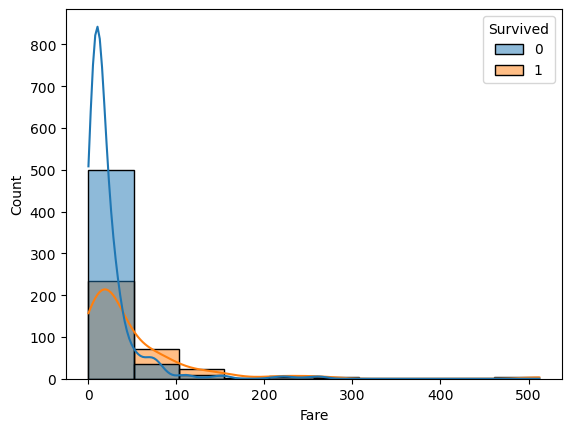

In [430]:
# Plotar histograma de 'Fare' com separação por 'Survived'
sns.histplot(data=train, x="Fare", bins=10, hue="Survived", kde=True)  # kde=True adiciona a curva de densidade
plt.show

In [431]:
# Criação das categorias de 'Fare' no conjunto de treino
'''
q=8
train['Fare_Category'] = pd.qcut(train['Fare'], q=q, labels=[f'Fare_Cat_{i+1}' for i in range(8)], duplicates='drop')

#APLICANDO AS CATEGORIAS TAMBÉM EM TEST:
# Obtém os limites (bins) usados em train['Fare_Category']
bins_train = train['Fare_Category'].cat.categories  # Isso obtém os rótulos, mas precisamos dos limites reais
bins_train = pd.qcut(train['Fare'], q=8, retbins=True)[1]  # Obtém os limites reais

# Rótulos para as categorias
labels = [f'Fare_Cat_{i+1}' for i in range(len(bins_train) - 1)]

# Aplica as mesmas categorias no conjunto de teste
test['Fare_Category'] = pd.cut(test['Fare'], bins=bins_train, labels=labels, right=True)

# Converte Fare_Category para tipo de objeto
train['Fare_Category'] = train['Fare_Category'].astype(object)
test['Fare_Category'] = test['Fare_Category'].astype(object)

# Exibe os resultados
print(train[['Fare', 'Fare_Category']])
print(test[['Fare', 'Fare_Category']])
'''

"\nq=8\ntrain['Fare_Category'] = pd.qcut(train['Fare'], q=q, labels=[f'Fare_Cat_{i+1}' for i in range(8)], duplicates='drop')\n\n#APLICANDO AS CATEGORIAS TAMBÉM EM TEST:\n# Obtém os limites (bins) usados em train['Fare_Category']\nbins_train = train['Fare_Category'].cat.categories  # Isso obtém os rótulos, mas precisamos dos limites reais\nbins_train = pd.qcut(train['Fare'], q=8, retbins=True)[1]  # Obtém os limites reais\n\n# Rótulos para as categorias\nlabels = [f'Fare_Cat_{i+1}' for i in range(len(bins_train) - 1)]\n\n# Aplica as mesmas categorias no conjunto de teste\ntest['Fare_Category'] = pd.cut(test['Fare'], bins=bins_train, labels=labels, right=True)\n\n# Converte Fare_Category para tipo de objeto\ntrain['Fare_Category'] = train['Fare_Category'].astype(object)\ntest['Fare_Category'] = test['Fare_Category'].astype(object)\n\n# Exibe os resultados\nprint(train[['Fare', 'Fare_Category']])\nprint(test[['Fare', 'Fare_Category']])\n"

In [432]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Relatives,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,NaN
5,6,0,3,"Moran, Mr. James",male,33.0,0,0,330877,8.4583,NaN,Q,Mr,0,NaN
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr,0,E
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master,4,NaN
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs,2,NaN
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs,1,NaN


In [433]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Relatives,Deck
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,0,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,1,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,0,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,0,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,2,NaN
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,Mr,0,NaN
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,Miss,0,NaN
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,Mr,2,NaN
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,Mrs,0,NaN
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,Mr,2,NaN


In [434]:
'''
# Verifica a quantidade de valores nulos em 'Deck'
print("Valores nulos iniciais em 'Deck':", train['Deck'].isnull().sum())

# Calcula a moda para cada categoria de 'Fare_Category', ignorando NaNs
modes = train.groupby('Fare_Category')['Deck'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

# Substitui modas que são None por um valor padrão, se necessário (por exemplo, 'Unknown')
modes.fillna('Unknown', inplace=True)

# Verifica as modas calculadas
print("Modas calculadas por 'Fare_Category':")
print(modes)
'''

'\n# Verifica a quantidade de valores nulos em \'Deck\'\nprint("Valores nulos iniciais em \'Deck\':", train[\'Deck\'].isnull().sum())\n\n# Calcula a moda para cada categoria de \'Fare_Category\', ignorando NaNs\nmodes = train.groupby(\'Fare_Category\')[\'Deck\'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)\n\n# Substitui modas que são None por um valor padrão, se necessário (por exemplo, \'Unknown\')\nmodes.fillna(\'Unknown\', inplace=True)\n\n# Verifica as modas calculadas\nprint("Modas calculadas por \'Fare_Category\':")\nprint(modes)\n'

In [435]:
dataset = [train, test] # Cria o dataset para trabalhar com train e test ao mesmo tempo na substituição da moda.
'''
# Função para preencher valores nulos
def fill_deck(row):
    if pd.notnull(row['Deck']):
        return row['Deck']
    else:
        return modes.get(row['Fare_Category'], 'Unknown')  # Use o valor padrão se não houver moda

# Aplica a função para preencher valores nulos
train['Deck'] = train.apply(fill_deck, axis=1)
test['Deck'] = test.apply(fill_deck, axis=1)

# Verifica novamente a quantidade de valores nulos após o preenchimento
print("Valores nulos finais em 'Deck':", train['Deck'].isnull().sum())
print("Valores nulos finais em 'Deck':", test['Deck'].isnull().sum())

# Garante que o tipo original de Deck seja mantido
train['Deck'] = train['Deck'].astype(train['Deck'].dtype)
test['Deck'] = test['Deck'].astype(test['Deck'].dtype)

# Exibe o DataFrame atualizado para verificação
train.head(10)
'''

'\n# Função para preencher valores nulos\ndef fill_deck(row):\n    if pd.notnull(row[\'Deck\']):\n        return row[\'Deck\']\n    else:\n        return modes.get(row[\'Fare_Category\'], \'Unknown\')  # Use o valor padrão se não houver moda\n\n# Aplica a função para preencher valores nulos\ntrain[\'Deck\'] = train.apply(fill_deck, axis=1)\ntest[\'Deck\'] = test.apply(fill_deck, axis=1)\n\n# Verifica novamente a quantidade de valores nulos após o preenchimento\nprint("Valores nulos finais em \'Deck\':", train[\'Deck\'].isnull().sum())\nprint("Valores nulos finais em \'Deck\':", test[\'Deck\'].isnull().sum())\n\n# Garante que o tipo original de Deck seja mantido\ntrain[\'Deck\'] = train[\'Deck\'].astype(train[\'Deck\'].dtype)\ntest[\'Deck\'] = test[\'Deck\'].astype(test[\'Deck\'].dtype)\n\n# Exibe o DataFrame atualizado para verificação\ntrain.head(10)\n'

In [436]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Relatives,Deck
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,0,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,1,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,0,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,0,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,2,NaN
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,Mr,0,NaN
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,Miss,0,NaN
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,Mr,2,NaN
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,Mrs,0,NaN
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,Mr,2,NaN


<AxesSubplot:xlabel='Deck', ylabel='count'>

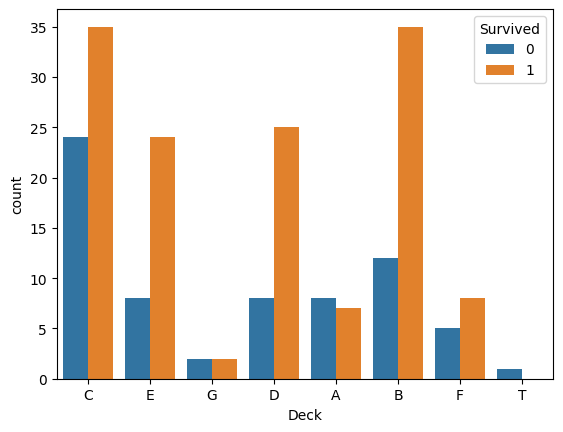

In [437]:
sns.countplot(data=train, x="Deck", hue="Survived")

In [438]:
#Verificando "Nan"
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Title        891 non-null    object 
 13  Relatives    891 non-null    int64  
 14  Deck         204 non-null    object 
dtypes: float64(2), int64(6), object(7)
memory usage: 80.1+ KB


### Changing categorical variables to ordinal

In [439]:
# Transformando a variável categórica 'Sex' em discreta
dataset = [train, test]
for data in dataset:
    data['Sex'] = data['Sex'].map({'female': 0, 'male': 1})

In [440]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for data in dataset:
    #data['Embarked']= encoder.fit_transform(data['Embarked']) #Faz sentido transformar em ordinal pois traz a ordem que o indivíduo embarcou
    data['Title'] = encoder.fit_transform(data['Title']) #Faz sentido transformar em ordinal (?)
    data['Deck'] = encoder.fit_transform(data['Deck']) #Quando aplico LabelEncoder em "Deck", os valores de NaN viram uma categoria automaticamente
    
#    data['Fare_Category'] = encoder.fit_transform(data['Fare_Category']) #Faz sentido transformar em ordinal

In [441]:
from sklearn.preprocessing import OneHotEncoder
dataset = [train, test]
# Crie uma instância do OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Itere sobre a lista de DataFrames
for i in range(len(dataset)):
    # Ajuste o encoder aos dados da coluna 'Embarked' do DataFrame atual
    encoder.fit(dataset[i][['Embarked']])  # Corrigido: Acessando o DataFrame pelo índice

    # Transforme os dados da coluna 'Embarked' do DataFrame atual
    encoded_data = encoder.transform(dataset[i][['Embarked']])  # Corrigido

    # Crie um novo DataFrame com as colunas codificadas
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Embarked']))

    # Concatene o DataFrame codificado ao DataFrame original
    dataset[i] = pd.concat([dataset[i], encoded_df], axis=1)  # Corrigido

    # Remova a coluna original 'Embarked' do DataFrame atual
    dataset[i].drop('Embarked', axis=1, inplace=True)  # Corrigido

train, test = dataset
# Acesse o primeiro DataFrame da lista (índice 0)
#print(dataset)

In [442]:
train["Deck"].unique()

array([8, 2, 4, 6, 3, 0, 1, 5, 7])

In [443]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Title        891 non-null    int32  
 12  Relatives    891 non-null    int64  
 13  Deck         891 non-null    int32  
 14  Embarked_C   891 non-null    float64
 15  Embarked_Q   891 non-null    float64
 16  Embarked_S   891 non-null    float64
dtypes: float64(5), int32(2), int64(7), object(3)
memory usage: 101.0+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,Relatives,Deck,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,1,8,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,3,1,2,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,8,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,3,1,2,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2,0,8,0.0,0.0,1.0


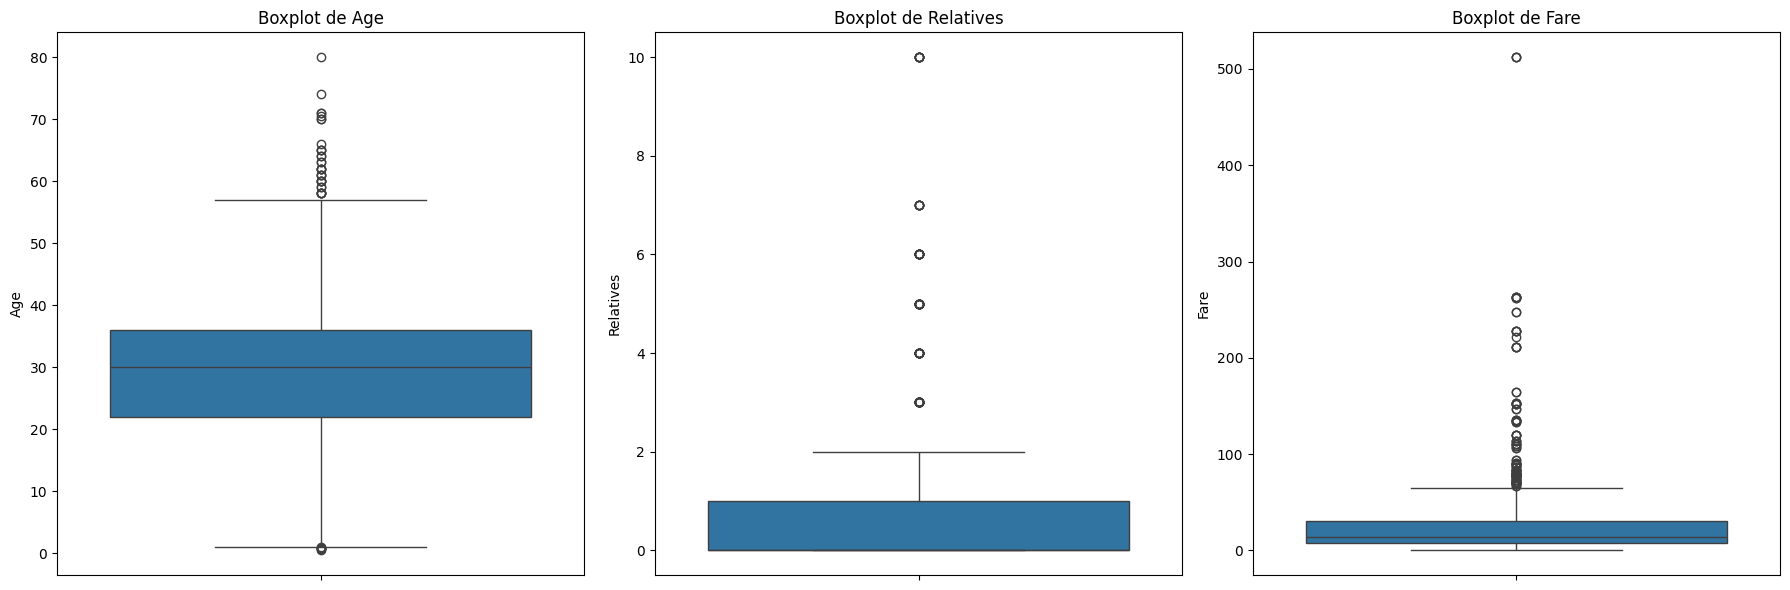

In [444]:
# Criar uma figura e três subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 linha, 3 colunas

# Plotar o boxplot de 'Age' no primeiro eixo
sns.boxplot(data=train, y='Age', ax=axes[0])
axes[0].set_title('Boxplot de Age')

# Plotar o boxplot de 'SibSp' no segundo eixo
sns.boxplot(data=train, y='Relatives', ax=axes[1])
axes[1].set_title('Boxplot de Relatives')

# Plotar o boxplot de 'Fare' no segundo eixo
sns.boxplot(data=train, y='Fare', ax=axes[2])
axes[2].set_title('Boxplot de Fare')

# Ajustar layout e mostrar o gráfico
plt.tight_layout()
plt.show()

In [445]:
Pid= test['PassengerId']

dataset= [train, test]
for data in dataset:
    data.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Title,Relatives,Deck,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,1,22.0,7.2500,2,1,8,0.0,0.0,1.0
1,2,1,1,0,38.0,71.2833,3,1,2,1.0,0.0,0.0
2,3,1,3,0,26.0,7.9250,1,0,8,0.0,0.0,1.0
3,4,1,1,0,35.0,53.1000,3,1,2,0.0,0.0,1.0
4,5,0,3,1,35.0,8.0500,2,0,8,0.0,0.0,1.0


In [446]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Title,Relatives,Deck,Embarked_C,Embarked_Q,Embarked_S
0,892,3,1,34.5,7.8292,3,0,7,0.0,1.0,0.0
1,893,3,0,47.0,7.0000,4,1,7,0.0,0.0,1.0
2,894,2,1,62.0,9.6875,3,0,7,0.0,1.0,0.0
3,895,3,1,27.0,8.6625,3,0,7,0.0,0.0,1.0
4,896,3,0,22.0,12.2875,4,2,7,0.0,0.0,1.0


In [447]:
corr_fare_surv = train['Fare'].corr(train['Survived'])
print(f"A correlação entre Fare e Survived é: {corr_fare_surv}")

corr_fare_deck = train['Fare'].corr(train['Deck'])
print(f"A correlação entre Fare e Deck é: {corr_fare_deck}")

corr_fare_deck = train['Pclass'].corr(train['Deck'])
print(f"A correlação entre Fare e Deck é: {corr_fare_deck}")

corr_deck_survived = train['Deck'].corr(train['Survived'])
print(f"A correlação entre Deck e Survived é: {corr_deck_survived}")

A correlação entre Fare e Survived é: 0.25730652238496177
A correlação entre Fare e Deck é: -0.5230133923964833
A correlação entre Fare e Deck é: 0.7466157070176204
A correlação entre Deck e Survived é: -0.3011159409577989


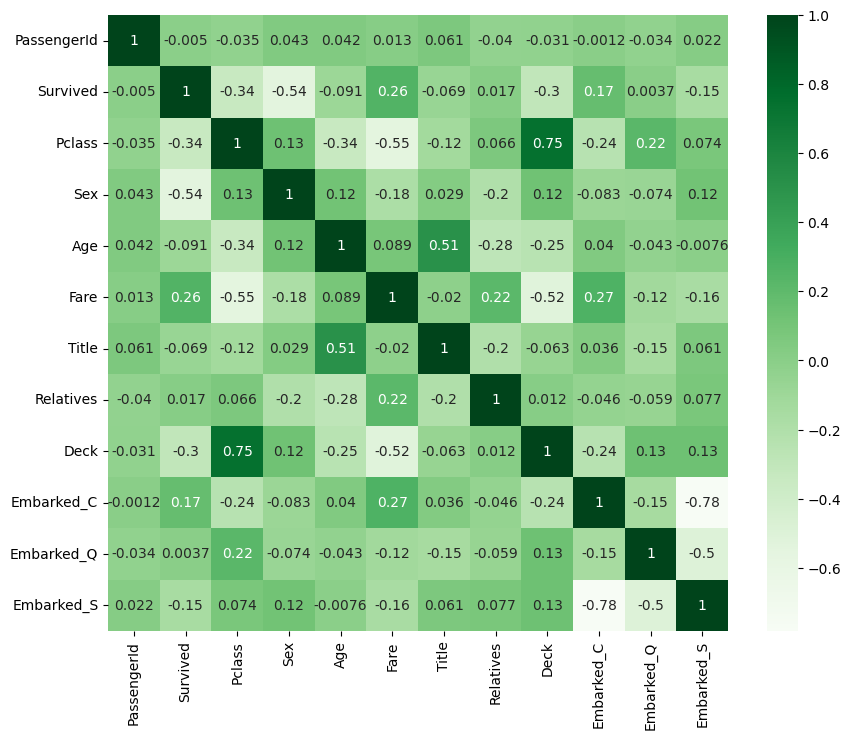

In [448]:
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(), annot=True, cmap='Greens')
plt.show()

### Normalização (Min / Max)

In [449]:
# Normalização não necessária para RegLog, a própria saída já comprime entre 0 e 1.
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
'''
train_norm = train
test_norm = test
features= ['Pclass', 'Sex', 'Age', 'Title', 'Relatives']
train_norm[features]= scaler.fit_transform(train_norm[features])
test_norm[features]= scaler.fit_transform(test_norm[features])
train_norm.head()
'''

"\ntrain_norm = train\ntest_norm = test\nfeatures= ['Pclass', 'Sex', 'Age', 'Title', 'Relatives']\ntrain_norm[features]= scaler.fit_transform(train_norm[features])\ntest_norm[features]= scaler.fit_transform(test_norm[features])\ntrain_norm.head()\n"

## Treinamento e Validação

In [450]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss, mean_squared_error
from sklearn.model_selection import KFold

In [452]:
y = train['Survived']
features_to_predict = ['Pclass', 'Sex', 'Age', 'Fare', 'Title','Relatives', 'Deck', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
X = train[features_to_predict]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

,Pclass,Sex,Age,Fare,Title,Relatives,Deck,Embarked_C,Embarked_Q,Embarked_S
331,1,1,45.5,28.5000,2,0,2,0.0,0.0,1.0
733,2,1,23.0,13.0000,2,0,8,0.0,0.0,1.0
382,3,1,32.0,7.9250,2,0,8,0.0,0.0,1.0
704,3,1,26.0,7.8542,2,1,8,0.0,0.0,1.0
813,3,0,6.0,31.2750,1,6,8,0.0,0.0,1.0


In [453]:
# Normalizando os dados (recomendado para variáveis numéricas)
#scaler = StandardScaler()
#X[features_to_predict] = scaler.fit_transform(X[features_to_predict])

# Configurando o KFold para alternar o conjunto de dados
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Listas para armazenar as métricas de cada fold
accuracies = []
precisions = []
confusion_matrices = []

# Loop para treinar e validar o modelo em cada fold
for train_index, val_index in kf.split(X):
    # Dividindo os dados em treino e validação para cada fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Inicializando e treinando o modelo
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    # Fazendo previsões e calculando as métricas para o conjunto de validação
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    # Salvando as métricas
    accuracies.append(accuracy)
    precisions.append(precision)
    confusion_matrices.append(cm)

    # Exibindo as métricas de cada fold
    print(f"Fold Accuracy: {accuracy}")
    print(f"Fold Precision: {precision}")
    print(f"Fold Confusion Matrix:\n{cm}\n")

# Exibindo as métricas agregadas após todos os folds
print(f"\nCross-Validation Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Cross-Validation Mean Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")

Fold Accuracy: 0.8666666666666667
Fold Precision: 0.8157894736842105
Fold Confusion Matrix:
[[47  7]
 [ 5 31]]

Fold Accuracy: 0.7752808988764045
Fold Precision: 0.78125
Fold Confusion Matrix:
[[44  7]
 [13 25]]

Fold Accuracy: 0.8089887640449438
Fold Precision: 0.8125
Fold Confusion Matrix:
[[46  6]
 [11 26]]

Fold Accuracy: 0.7528089887640449
Fold Precision: 0.6666666666666666
Fold Confusion Matrix:
[[51  8]
 [14 16]]

Fold Accuracy: 0.797752808988764
Fold Precision: 0.7631578947368421
Fold Confusion Matrix:
[[42  9]
 [ 9 29]]

Fold Accuracy: 0.8539325842696629
Fold Precision: 0.8518518518518519
Fold Confusion Matrix:
[[53  4]
 [ 9 23]]

Fold Accuracy: 0.7528089887640449
Fold Precision: 0.6774193548387096
Fold Confusion Matrix:
[[46 10]
 [12 21]]

Fold Accuracy: 0.6629213483146067
Fold Precision: 0.5483870967741935
Fold Confusion Matrix:
[[42 14]
 [16 17]]

Fold Accuracy: 0.7191011235955056
Fold Precision: 0.7142857142857143
Fold Confusion Matrix:
[[39 10]
 [15 25]]

Fold Accuracy: 0

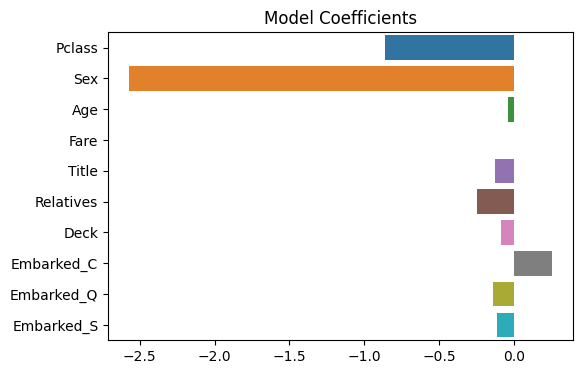

In [454]:
coefs = pd.DataFrame(model.coef_.T, index=X_train.columns, columns=['beta_value'])
plt.figure(figsize=(6, 4))
sns.barplot(data=coefs.T, orient='h').set(title='Model Coefficients');
plt.show()

In [455]:
model_fi = permutation_importance(model, X_train,y_train)
model_fi['importances_mean']                    # array([0.07 , 0.352, 0.02 ])

array([ 0.02942643,  0.21995012,  0.0127182 , -0.00024938,  0.00124688,
       -0.00199501, -0.00648379,  0.00024938, -0.00149626,  0.00299252])

## Previsão dos dados de Teste

In [456]:
#test = pd.read_csv('titanic/test.csv') #Valores reais do dataset de test

In [457]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Title,Relatives,Deck,Embarked_C,Embarked_Q,Embarked_S
0,892,3,1,34.5,7.8292,3,0,7,0.0,1.0,0.0
1,893,3,0,47.0,7.0000,4,1,7,0.0,0.0,1.0
2,894,2,1,62.0,9.6875,3,0,7,0.0,1.0,0.0
3,895,3,1,27.0,8.6625,3,0,7,0.0,0.0,1.0
4,896,3,0,22.0,12.2875,4,2,7,0.0,0.0,1.0


In [458]:
# Faça a previsão no dataset para prever
predictions = []
predictions = model.predict(test[features_to_predict])
print(type(predictions))
predictions = pd.DataFrame(predictions)
predictions[['Prob_previsão_0', 'Prob_previsão_1']] = pd.DataFrame(model.predict_proba(test[features_to_predict]))
print(type(predictions))
test[['Valor_previsto', 'Prob_previsão_0', 'Prob_previsão_1']] = predictions
test.head()

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


,PassengerId,Pclass,Sex,Age,Fare,Title,Relatives,Deck,Embarked_C,Embarked_Q,Embarked_S,Valor_previsto,Prob_previsão_0,Prob_previsão_1
0,892,3,1,34.5,7.8292,3,0,7,0.0,1.0,0.0,0,0.910838,0.089162
1,893,3,0,47.0,7.0000,4,1,7,0.0,0.0,1.0,0,0.640536,0.359464
2,894,2,1,62.0,9.6875,3,0,7,0.0,1.0,0.0,0,0.924870,0.075130
3,895,3,1,27.0,8.6625,3,0,7,0.0,0.0,1.0,0,0.881360,0.118640
4,896,3,0,22.0,12.2875,4,2,7,0.0,0.0,1.0,1,0.465292,0.534708


In [459]:
df_real_values = pd.read_csv('titanic/gender_submission.csv') #Valores reais do dataset de test
df_real_values.head(300)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
295,1187,0
296,1188,1
297,1189,0
298,1190,0


In [460]:
#Testando acurácia da previsão dos dados de test
accuracy = accuracy_score(df_real_values['Survived'],test['Valor_previsto'])
precisao = precision_score(df_real_values['Survived'],test['Valor_previsto'])
print(f"Acuracy: {accuracy}")
print(f'Precisão: {precisao}')
print(confusion_matrix(df_real_values['Survived'],test['Valor_previsto']))

Acuracy: 0.9210526315789473
Precisão: 0.8888888888888888
[[249  17]
 [ 16 136]]


In [461]:
#Data Frame Final com a Predição

test = pd.read_csv('titanic/test.csv') #Importando o DataSet de Teste Original

test[['Valor_previsto', 'Prob_previsão_0', 'Prob_previsão_1']] = predictions #Atribuindo as colunas de teste

df_test_predicted = pd.merge(test, df_real_values, on='PassengerId', how='left')

df_test_predicted.to_csv('df_test_predicted.csv', index=False)

df_test_predicted.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Valor_previsto,Prob_previsão_0,Prob_previsão_1,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0.910838,0.089162,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0.640536,0.359464,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0.924870,0.075130,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0.881360,0.118640,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0.465292,0.534708,1


In [462]:
#DataFram para submeter

df_test_predicted_submission = pd.DataFrame()

df_test_predicted_submission[['PassengerId','Survived']] = df_test_predicted[['PassengerId', 'Valor_previsto']]

df_test_predicted_submission.to_csv('df_test_predicted_submission.csv', index=False)

df_test_predicted_submission.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
